# Experimenting with models - Face Mask Detection
## Description
description here

## Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import pathlib

# sets the path to the home directory of this repository so other modules can be imported. 
root_path = os.path.split(os.path.split(os.getcwd())[0])[0]
assert root_path.endswith("mask-detection"), "The root path does not end with mask-detection: " + root_path 
sys.path.insert(0, root_path)
path = pathlib.Path(root_path + '/data/facemask-dataset')

# set the seed for reproducible results.
np.random.seed(0)
tf.random.set_seed(0)

# GPU settings
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print(tf.__version__)

2.3.0


In [2]:
from datasets.facemask_dataset import FacemaskDataset
batch_size = 64
train_percentage = 0.6
validation_percentage = 0.2
test_percentage = 0.2
ds = FacemaskDataset(path, batch_size, 200, 200, True, train_percentage, validation_percentage, test_percentage)

train: 36 validation: 12 test: 12


## Building models

In [3]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

num_classes = 2

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(num_classes)
])

In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Add a callback for earlystopping
callbacks = [EarlyStopping(patience=10, monitor='val_loss')]

history = model.fit(
    x=ds.train_ds,
    validation_data=ds.val_ds,
    epochs=100,
    validation_steps=ds.val_size,
    steps_per_epoch=ds.train_size,
    callbacks=callbacks
)

Epoch 1/100
36/36 [==============================] - 54s 2s/step - loss: 0.6931 - acc: 0.5117 - val_loss: 0.6923 - val_acc: 0.6615
Epoch 2/100
36/36 [==============================] - 1s 41ms/step - loss: 0.6897 - acc: 0.5582 - val_loss: 0.6862 - val_acc: 0.6159
Epoch 3/100
36/36 [==============================] - 1s 40ms/step - loss: 0.6756 - acc: 0.5985 - val_loss: 0.6679 - val_acc: 0.6315
Epoch 4/100
36/36 [==============================] - 1s 40ms/step - loss: 0.6464 - acc: 0.6519 - val_loss: 0.6260 - val_acc: 0.7018
Epoch 5/100
36/36 [==============================] - 1s 40ms/step - loss: 0.6065 - acc: 0.6845 - val_loss: 0.5822 - val_acc: 0.7240
Epoch 6/100
36/36 [==============================] - 1s 40ms/step - loss: 0.5637 - acc: 0.7153 - val_loss: 0.5356 - val_acc: 0.7448
Epoch 7/100
36/36 [==============================] - 1s 40ms/step - loss: 0.5148 - acc: 0.7648 - val_loss: 0.5060 - val_acc: 0.7344
Epoch 8/100
36/36 [==============================] - 1s 40ms/step - loss: 0.4

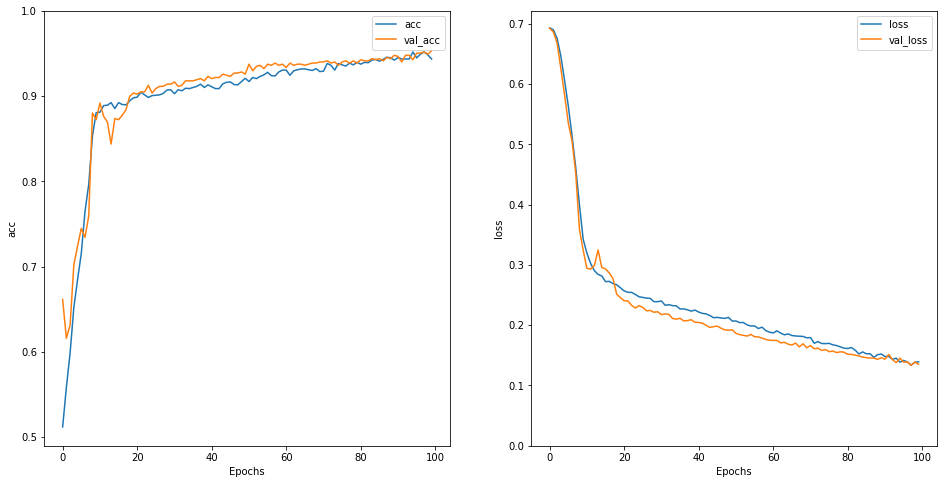

In [11]:
def visualise_results(history):
    def plot_graph(history, metric):
        plt.plot(history.history[metric])
        plt.plot(history.history['val_'+metric], '')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend([metric, 'val_'+metric])

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plot_graph(history, 'acc')
    plt.ylim(None,1)
    plt.subplot(1,2,2)
    plot_graph(history, 'loss')
    plt.ylim(0,None)

visualise_results(history)